In [13]:
import argparse
import base64
import numpy as np
import pandas as pd
import seaborn as sns
import torch


from io import BytesIO
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import deep_learning_models

from tinyphysics_modified import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX

ROLL_LATA_MEAN = 0.12531
ROLL_LATA_STD = 0.264393
V_EGO_MEAN = 23.2602
V_EGO_STD = 9.40597
A_EGO_MEAN = 0.027936
A_EGO_STD = 0.4448
LAT_ACC_MEAN = 0.0125555
LAT_ACC_STD = 0.567619 

sns.set_theme()
SAMPLE_ROLLOUTS = 5

class BaseController:
  def update(self, target_lataccel, current_lataccel, state):
    raise NotImplementedError
  
class GoodPIDController(BaseController):
  def __init__(self, kp=0.08852291, ki=0.07724999, kd=-0.05190457):
    self.kp = kp
    self.ki = ki
    self.kd = kd
    self.lstm_model = deep_learning_models.lstm_model
    self.last_err = 0
    self.int = 0
    
  def update(self, target_lataccel, current_lataccel, state):
    curr_err = target_lataccel - current_lataccel
    deriv = curr_err - self.prev_err
    self.int += curr_err
    self.last_err = curr_err
    
    output = self.kp * curr_err + self.ki * self.int + self.kd * deriv
    
    input_tensor = torch.tensor([[
            (state[0] - ROLL_LATA_MEAN)/ROLL_LATA_STD,
            (state[1] - V_EGO_MEAN)/V_EGO_STD,
            (state[2] - A_EGO_MEAN)/A_EGO_STD,
        ]], dtype=torch.float32)

    #Forward pass through LSTM model
    with torch.no_grad():
        lstm_output, _ = self.lstm_model(input_tensor.unsqueeze(0))

    predicted_output = lstm_output.item()

    output += 1 * predicted_output
    output = float(output)
    
    return output
  
class GoodPIDController(BaseController):
  def __init__(self, kp=0.08852291, ki=0.07724999, kd=-0.05190457):
    self.kp = kp
    self.ki = ki
    self.kd = kd
    self.lstm_model = deep_learning_models.lstm_model
    self.last_err = 0
    self.int = 0
    
  def update(self, target_lataccel, current_lataccel, state):
    curr_err = target_lataccel - current_lataccel
    deriv = curr_err - self.prev_err
    self.int += curr_err
    self.last_err = curr_err
    
    output = self.kp * curr_err + self.ki * self.int + self.kd * deriv
    
    return output
  
class SimpleController(BaseController):
  """
  A simple controller that is the error between the target and current lateral acceleration times some factor
  """
  def update(self, target_lataccel, current_lataccel, state):
    return (target_lataccel - current_lataccel) * 0.3


def img2base64(fig):
  buf = BytesIO()
  fig.savefig(buf, format='png')
  data = base64.b64encode(buf.getbuffer()).decode("ascii")
  return data


def create_report(test, baseline, sample_rollouts, costs):
  res = []
  res.append("<h1>Comma Controls Challenge: Report</h1>")
  res.append(f"<b>Test Controller: {test}, Baseline Controller: {baseline}</b>")

  res.append("<h2>Aggregate Costs</h2>")
  res_df = pd.DataFrame(costs)
  fig, axs = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)
  bins = np.arange(0, 1000, 10)
  for ax, cost in zip(axs, ['lataccel_cost', 'jerk_cost', 'total_cost']):
    for controller in ['test', 'baseline']:
      ax.hist(res_df[res_df['controller'] == controller][cost], bins=bins, label=controller, alpha=0.5)
    ax.set_xlabel('Cost')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Cost Distribution: {cost}')
    ax.legend()

  res.append(f'<img src="data:image/png;base64,{img2base64(fig)}" alt="Plot">')
  res.append(res_df.groupby('controller').agg({'lataccel_cost': 'mean', 'jerk_cost': 'mean', 'total_cost': 'mean'}).round(3).reset_index().to_html(index=False))

  res.append("<h2>Sample Rollouts</h2>")
  fig, axs = plt.subplots(ncols=1, nrows=SAMPLE_ROLLOUTS, figsize=(15, 3 * SAMPLE_ROLLOUTS), sharex=True)
  for ax, rollout in zip(axs, sample_rollouts):
    ax.plot(rollout['desired_lataccel'], label='Desired Lateral Acceleration')
    ax.plot(rollout['test_controller_lataccel'], label='Test Controller Lateral Acceleration')
    ax.plot(rollout['baseline_controller_lataccel'], label='Baseline Controller Lateral Acceleration')
    ax.set_xlabel('Step')
    ax.set_ylabel('Lateral Acceleration')
    ax.set_title(f"Segment: {rollout['seg']}")
    ax.axline((CONTROL_START_IDX, 0), (CONTROL_START_IDX, 1), color='black', linestyle='--', alpha=0.5, label='Control Start')
    ax.legend()
  fig.tight_layout()
  res.append(f'<img src="data:image/png;base64,{img2base64(fig)}" alt="Plot">')

  with open("report.html", "w") as fob:
    fob.write("\n".join(res))
    print("Report saved to: './report.html'")


def main():

  tinyphysicsmodel = TinyPhysicsModel("./models/tinyphysics.onnx", debug=False)

  data_path = Path("./data")
  assert data_path.is_dir(), "data_path should be a directory"

  costs = []
  sample_rollouts = []
  files = sorted(data_path.iterdir())[:5000]
  for d, data_file in enumerate(tqdm(files, total=len(files))):
    test_controller = GoodPIDController()
    baseline_controller = SimpleController()
    test_sim = TinyPhysicsSimulator(tinyphysicsmodel, str(data_file), controller=test_controller, debug=False)
    test_cost = test_sim.rollout()
    baseline_sim = TinyPhysicsSimulator(tinyphysicsmodel, str(data_file), controller=baseline_controller, debug=False)
    baseline_cost = baseline_sim.rollout()

    if d < SAMPLE_ROLLOUTS:
      sample_rollouts.append({
        'seg': data_file.stem,
        'test_controller': GoodPIDController,
        'baseline_controller': SimpleController,
        'desired_lataccel': test_sim.target_lataccel_history,
        'test_controller_lataccel': test_sim.current_lataccel_history,
        'baseline_controller_lataccel': baseline_sim.current_lataccel_history,
      })

    costs.append({'seg': data_file.stem, 'controller': 'test', **test_cost})
    costs.append({'seg': data_file.stem, 'controller': 'baseline', **baseline_cost})

  return sample_rollouts, costs

sample_rollouts, costs = main()

100%|██████████| 5000/5000 [3:49:31<00:00,  2.75s/it]  


Report saved to: './report.html'


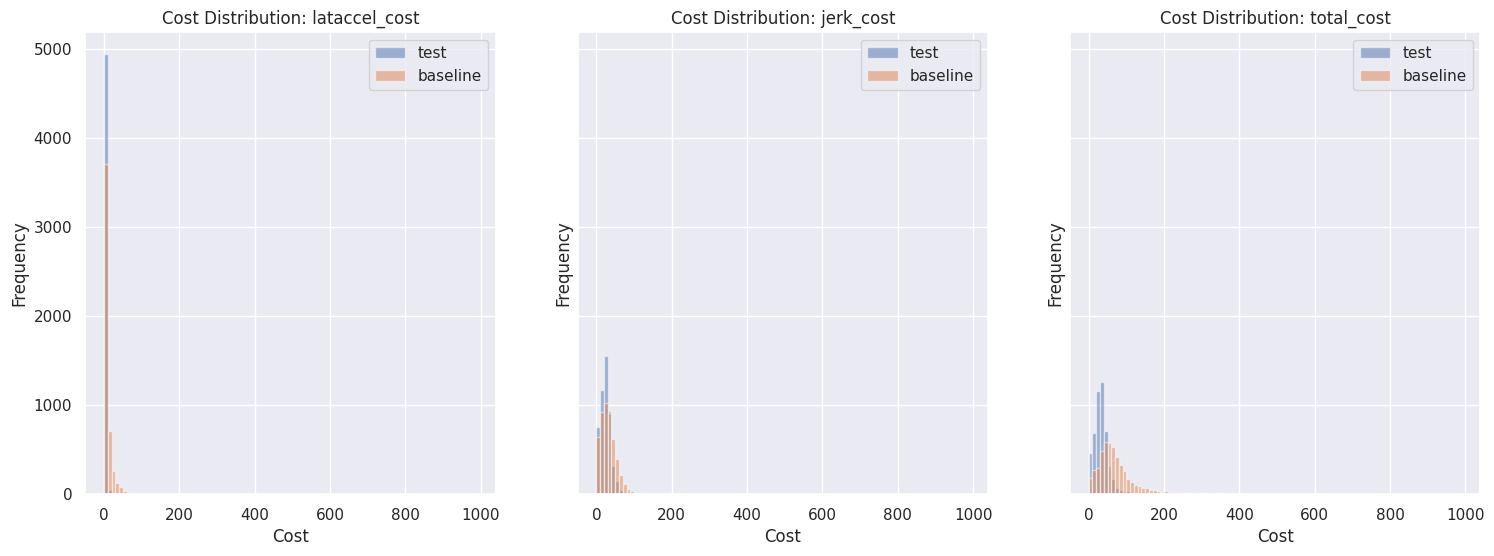

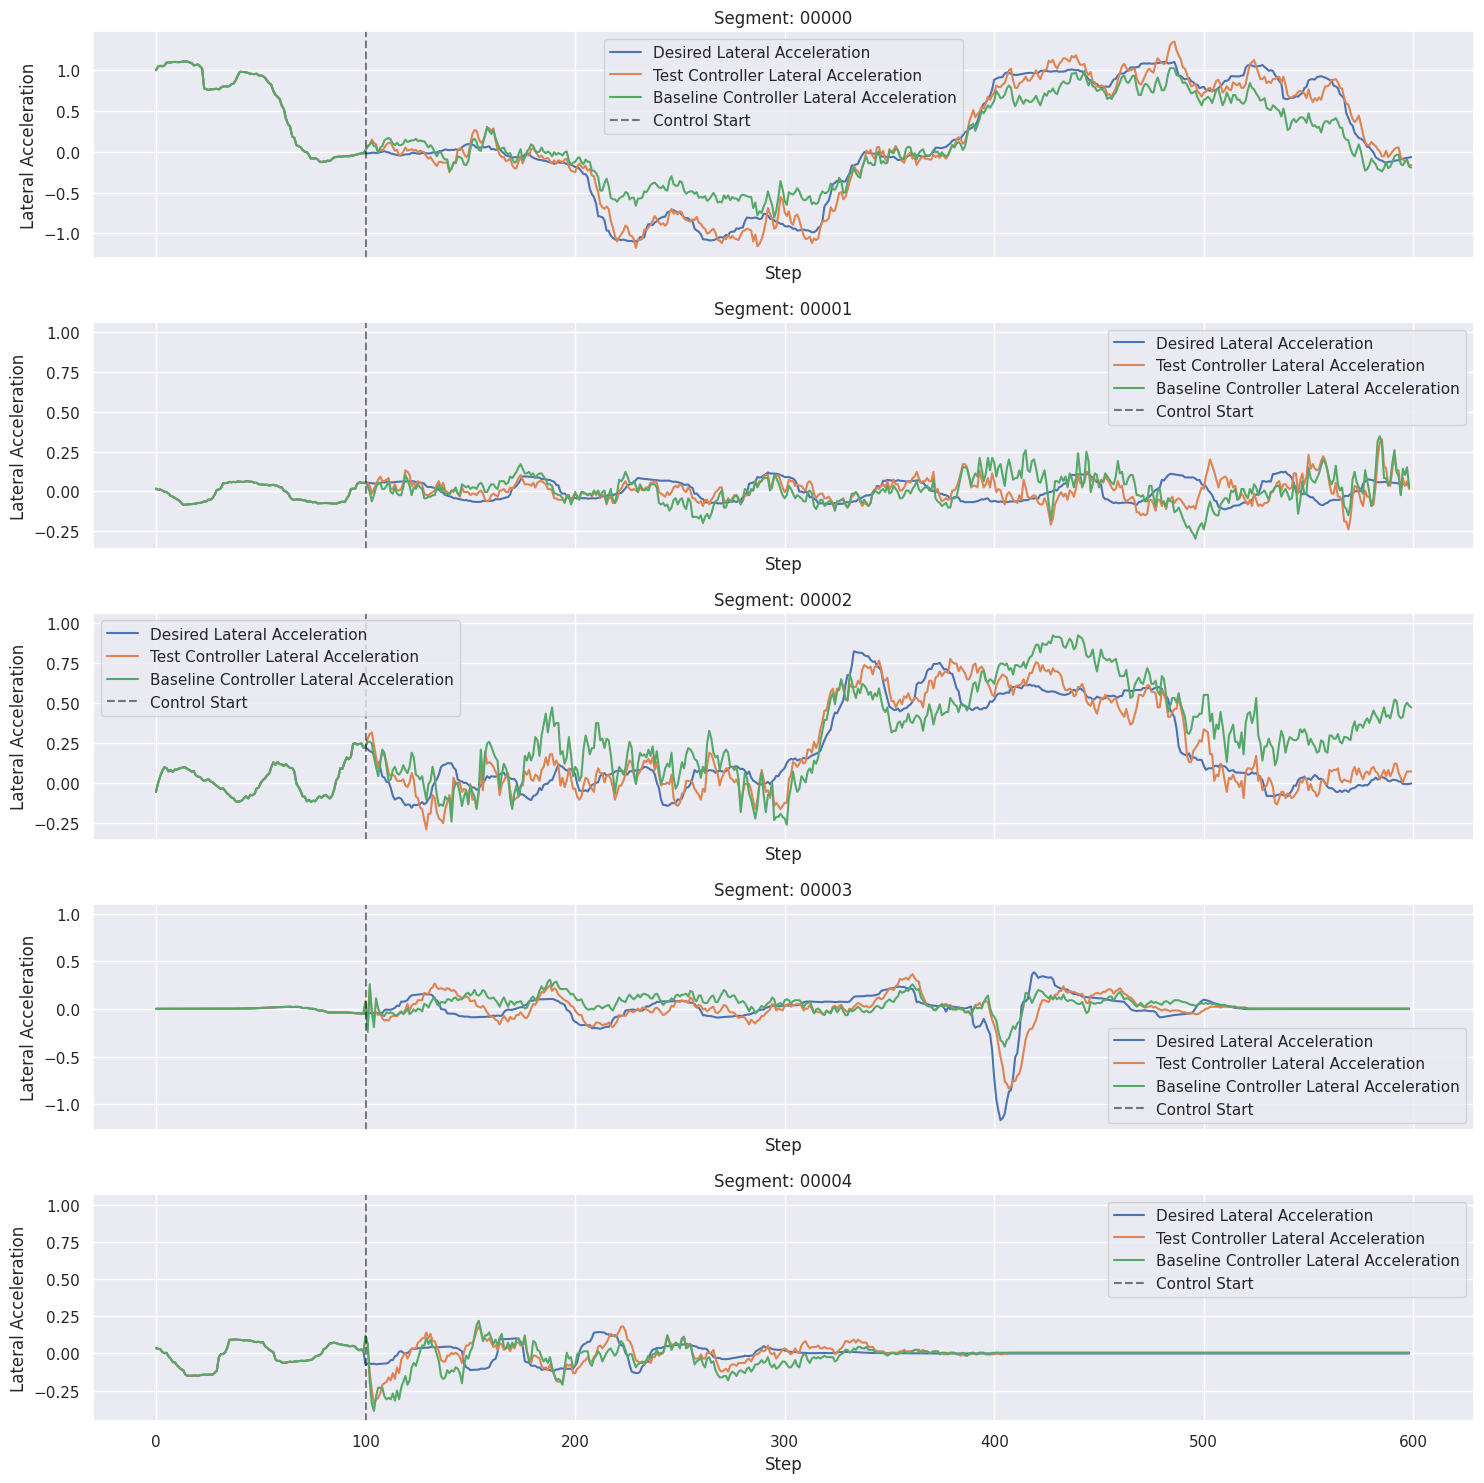

In [14]:
create_report('goodpid', 'simple', sample_rollouts, costs)